In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install yahoo-finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import библиотек
import yfinance as yf
import math 
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # специальное отображение графиков для pyplot

In [ ]:
import time
import datetime
import pandas as pd


tickers = ['TSLA', 'TWTR', 'MSFT', 'GOOG', 'AAPL', '^GSPC']
interval = '1d'
period1 = int(time.mktime(datetime.datetime(2012, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 5, 20, 23, 59).timetuple()))

xlwriter = pd.ExcelWriter('historical prices.xlsx', engine='openpyxl')
for ticker in tickers:
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(query_string)
    df.to_excel(xlwriter, sheet_name=ticker, index=False)

xlwriter.save()

In [ ]:
data = pd.ExcelFile('/content/historical prices.xlsx')

In [ ]:
aapl = pd.read_excel(data, 'AAPL')
df = aapl

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.557463,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.624949,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.765113,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.898556,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.878096,394024400
...,...,...,...,...,...,...,...
2609,2022-05-16,145.550003,147.520004,144.179993,145.539993,145.539993,86643800
2610,2022-05-17,148.860001,149.770004,146.679993,149.240005,149.240005,78336300
2611,2022-05-18,146.850006,147.360001,139.899994,140.820007,140.820007,109742900
2612,2022-05-19,139.880005,141.660004,136.600006,137.350006,137.350006,136095600


In [ ]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.557463,302220800,1
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.624949,260022000,1
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.765113,271269600,1
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.898556,318292800,1
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.878096,394024400,1
5,2012-01-10,15.211071,15.214286,15.053571,15.115714,12.924207,258196400,1
6,2012-01-11,15.095714,15.101786,14.975357,15.091071,12.903137,215084800,1
7,2012-01-12,15.081429,15.103571,14.955357,15.049643,12.867711,212587200,1
8,2012-01-13,14.989286,15.016071,14.952143,14.993214,12.819465,226021600,1
9,2012-01-17,15.150000,15.213929,15.105714,15.167857,12.968791,242897200,1


In [ ]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
test_size = 0.1                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [ ]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['open'])):
        X_train = np.array(range(len(df['open'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['open'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df = df.rename(columns={'Adj Close': 'adj_close'})
df = df.rename(columns={'Date': 'date'})

In [ ]:
df

,date,open,high,low,close,adj_close,volume,month
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.557463,302220800,1
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.624949,260022000,1
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.765113,271269600,1
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.898556,318292800,1
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.878096,394024400,1
...,...,...,...,...,...,...,...,...
2609,2022-05-16,145.550003,147.520004,144.179993,145.539993,145.539993,86643800,5
2610,2022-05-17,148.860001,149.770004,146.679993,149.240005,149.240005,78336300,5
2611,2022-05-18,146.850006,147.360001,139.899994,140.820007,140.820007,109742900,5
2612,2022-05-19,139.880005,141.660004,136.600006,137.350006,137.350006,136095600,5


Text(0, 0.5, 'USD')

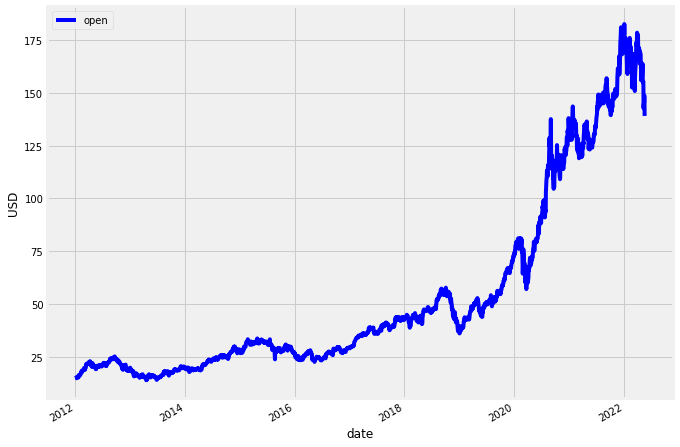

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='open', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1831
num_cv = 522
num_test = 261
train.shape = (1831, 8)
cv.shape = (522, 8)
train_cv.shape = (2353, 8)
test.shape = (261, 8)


Text(0, 0.5, 'USD')

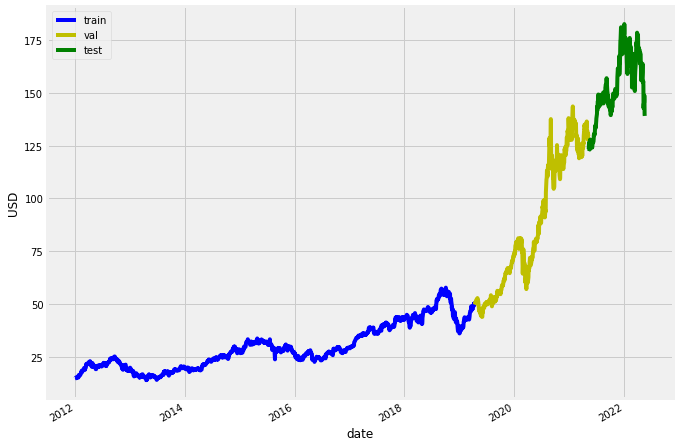

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='open', style='b-', grid=True)
ax = cv.plot(x='date', y='open', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='open', style='g-', grid=True, ax=ax)
ax.legend(['train', 'val', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'open', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['open'])))
    R2.append(r2_score(cv['open'], est_list))
    mape.append(get_mape(cv['open'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [2.1729976924757417, 3.131169013786252, 2.835639605445357, 2.737103407748586, 2.6878051340764983, 2.708837389988055, 2.734780824361806, 2.776773217673854, 2.832641644407527, 2.8746954181734927, 2.9252873980227077, 2.9817689457790184, 3.0462378472352785, 3.116081062454247, 3.1906071679969634, 3.260518418354597, 3.338509893001322, 3.41510837356439, 3.472971581364651, 3.521817734771612, 3.570230567990503, 3.6222102489668258, 3.682763138920787, 3.747967844486718, 3.816884798269583, 3.889759155863523, 3.969759853979777, 4.050047360311082, 4.125842338920713, 4.199656207616028]
R2 = [0.994991302823163, 0.9896003370048014, 0.9914707997290058, 0.9920532663743995, 0.992336947458046, 0.9922165504336227, 0.9920667471370002, 0.9918212474500796, 0.9914888250754428, 0.9912342330824694, 0.9909229793076768, 0.9905690765494268, 0.9901568554208381, 0.9897003198314177, 0.9892017614353373, 0.9887233640349213, 0.9881774385499832, 0.987628703237119, 0.9872059305416516, 0.9868435112959868, 0.9864793125

,date,open,high,low,close,adj_close,volume,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
1831,2019-04-15,49.645000,49.962502,49.502499,49.807499,48.426430,70146400,4,49.799999,49.387496,...,50.033440,50.058603,50.099219,50.163650,50.290975,50.478776,50.551047,50.580158,50.566403,50.543488
1832,2019-04-16,49.865002,50.342499,49.639999,49.812500,48.431293,102785600,4,49.645000,49.490001,...,50.108214,50.134707,50.161847,50.203768,50.268650,50.394269,50.578796,50.652896,50.685468,50.676471
1833,2019-04-17,49.884998,50.845001,49.652500,50.782501,49.374390,115627200,4,49.865002,50.085004,...,50.201869,50.227825,50.255089,50.283053,50.325275,50.389746,50.513013,50.693750,50.768811,50.803919
1834,2019-04-18,50.779999,51.037498,50.630001,50.965000,49.551830,96783200,4,49.884998,49.904994,...,50.320369,50.301818,50.329150,50.357762,50.387075,50.430123,50.494715,50.616250,50.793848,50.870126
1835,2019-04-22,50.707500,51.235001,50.584999,51.132500,49.714687,77758000,4,50.779999,51.675000,...,50.511333,50.560162,50.538784,50.561512,50.585974,50.611561,50.650776,50.711210,50.827149,50.998074


(2.0, 30.0)

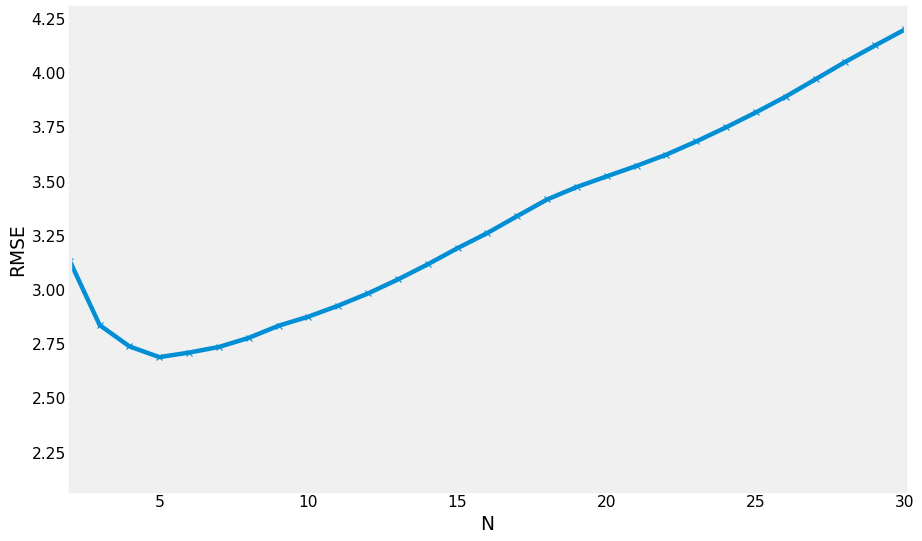

In [ ]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Text(0, 0.5, 'R2')

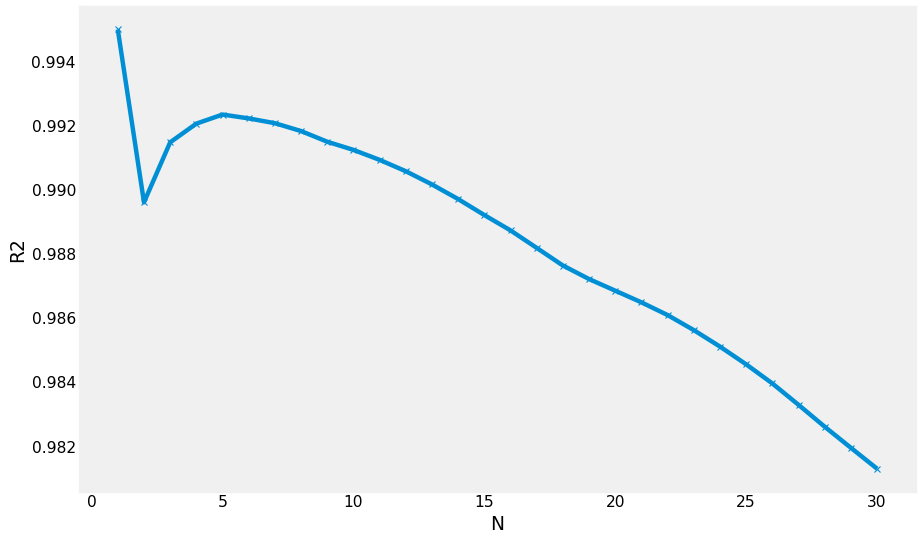

In [ ]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

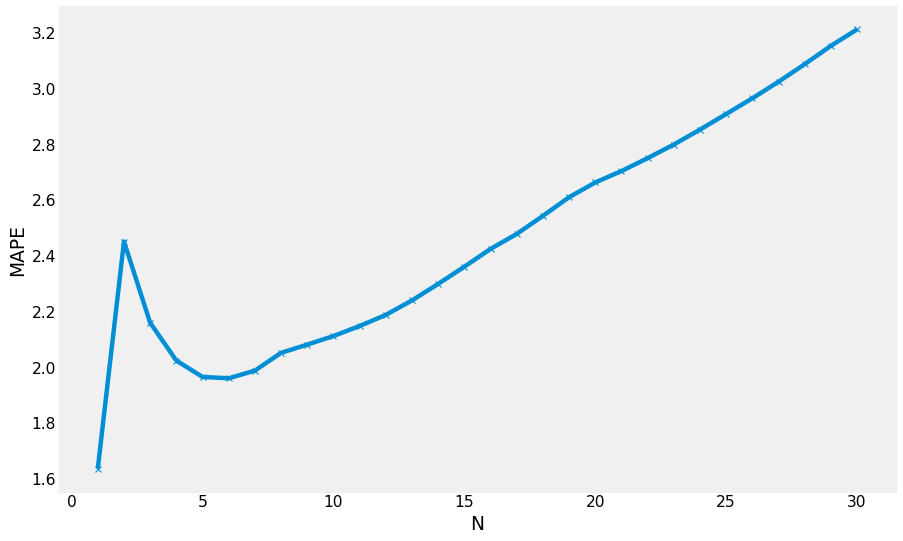

In [ ]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [ ]:
# Set optimum N
N_opt = 5

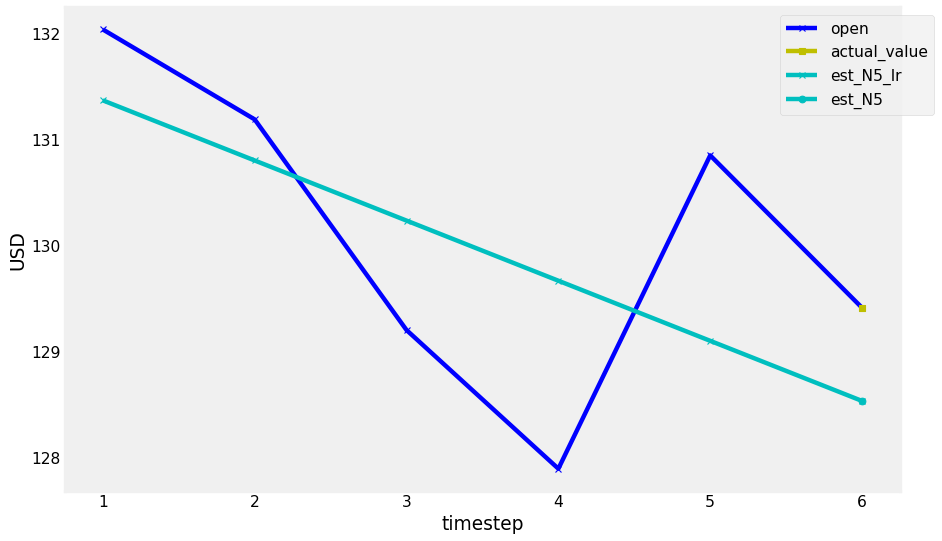

In [ ]:
day = pd.Timestamp(date(2022, 5, 20))


Nmax2 = 5

df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['open'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['open'], 'ys-')
legend_list = ['open', 'actual_value']


color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) 
for N in range(5, Nmax2+1):
    
    X_train = np.array(range(len(df_temp['open'][-N-1:-1]))) 
    y_train = np.array(df_temp['open'][-N-1:-1]) 
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            
    y_est = regr.predict(X_train)         
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

Text(0, 0.5, 'USD')

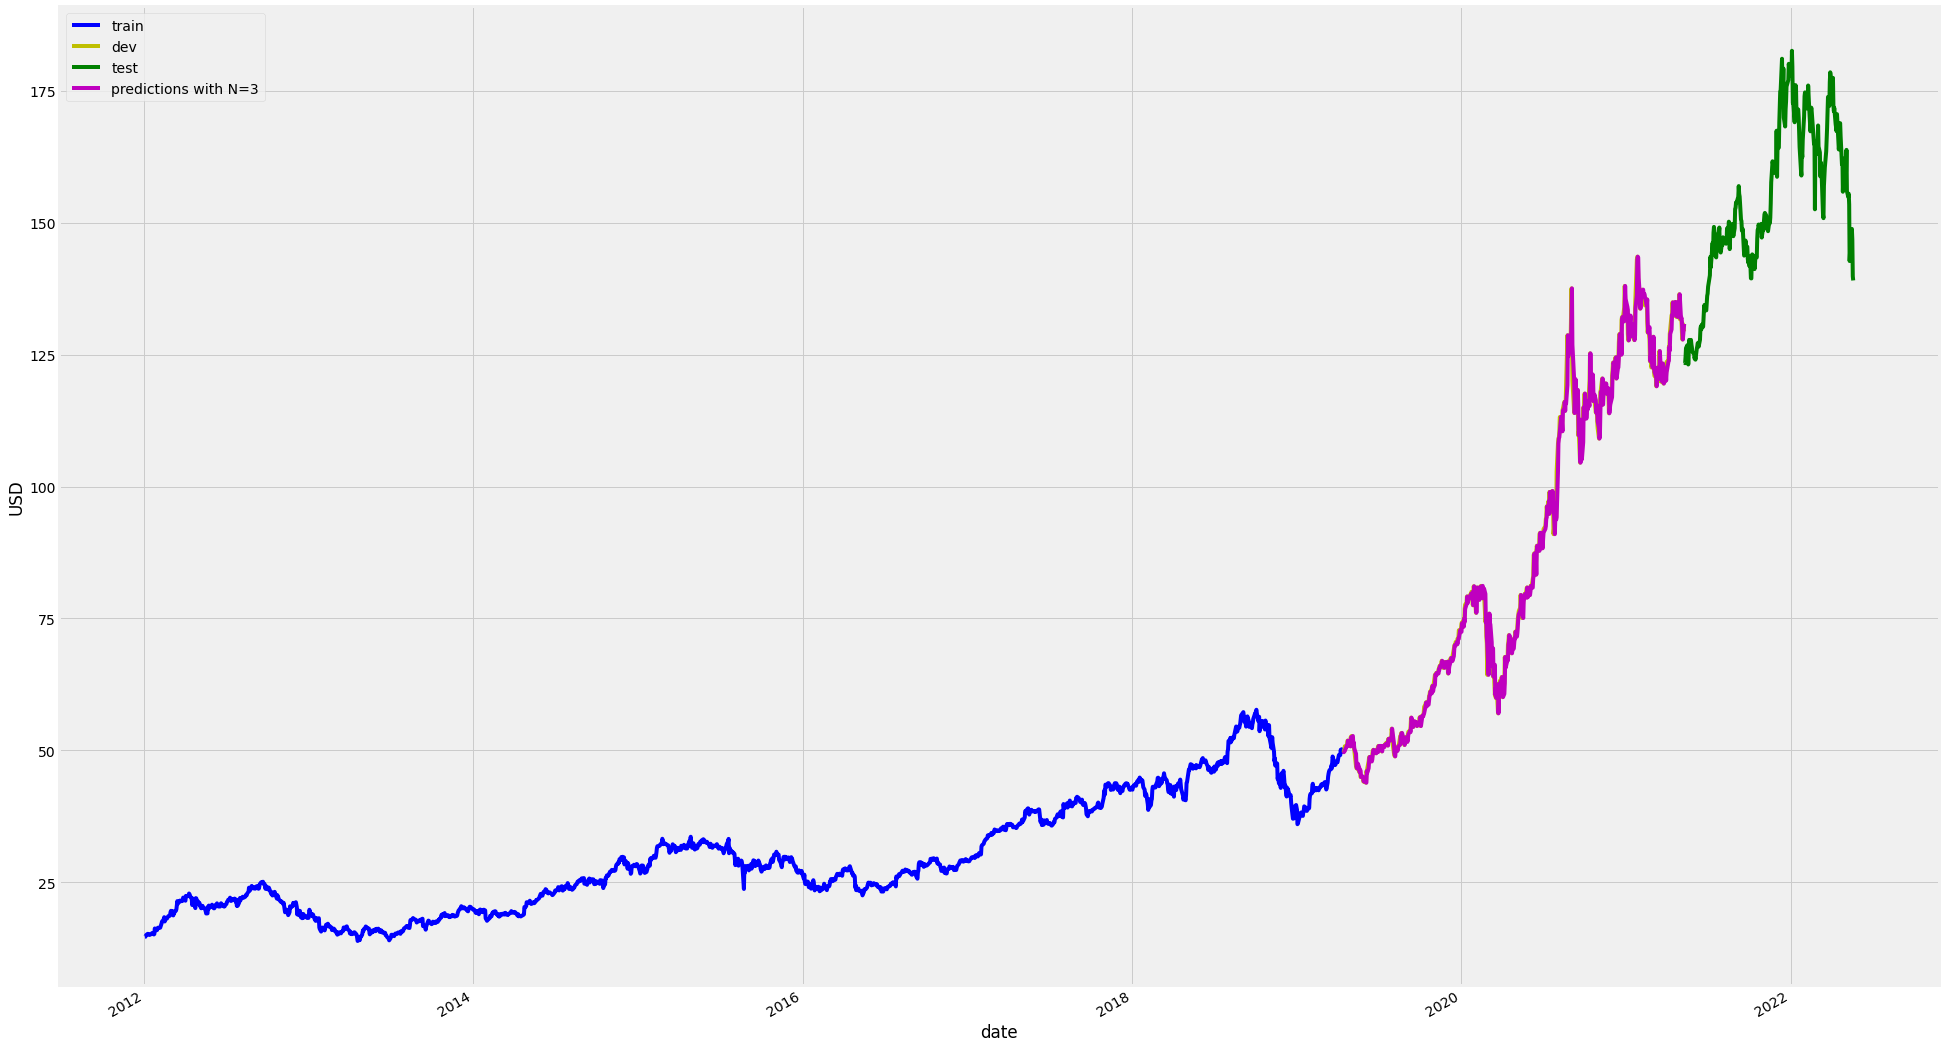

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 30, 20 # width 10, height 8

ax = train.plot(x='date', y='open', style='b-', grid=True)
ax = cv.plot(x='date', y='open', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='open', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=3'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

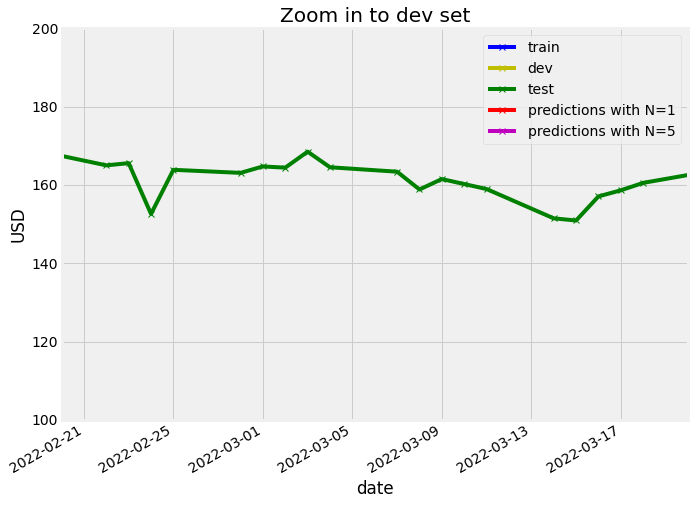

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='open', style='bx-', grid=True)
ax = cv.plot(x='date', y='open', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='open', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2022, 2, 20), date(2022, 3, 20)])
ax.set_ylim([100, 200])
ax.set_title('Zoom in to dev set')

In [ ]:
est_list = get_preds_lin_reg(df, 'open', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['open'])))
print("R2 = %0.3f" % r2_score(test['open'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['open'], est_list))
test.head()

RMSE = 3.477
R2 = 0.948
MAPE = 1.683%


,date,open,high,low,close,adj_close,volume,month,est_N12,est_N5
2353,2021-05-11,123.500000,126.269997,122.769997,125.910004,125.194733,126142800,5,128.525910,129.135005
2354,2021-05-12,123.400002,124.639999,122.250000,122.769997,122.072571,112172300,5,125.674699,125.206005
2355,2021-05-13,124.580002,126.150002,124.260002,124.970001,124.260071,105861300,5,123.750155,122.111002
2356,2021-05-14,126.250000,127.889999,125.849998,127.449997,126.725983,81918000,5,122.776670,120.783000
2357,2021-05-17,126.820000,126.930000,125.169998,126.269997,125.552681,74244600,5,122.685457,123.856000


In [ ]:
test.tail()

,date,open,high,low,close,adj_close,volume,month,est_N12,est_N5
2609,2022-05-16,145.550003,147.520004,144.179993,145.539993,145.539993,86643800,5,146.689242,140.233001
2610,2022-05-17,148.860001,149.770004,146.679993,149.240005,149.240005,78336300,5,144.132122,139.731000
2611,2022-05-18,146.850006,147.360001,139.899994,140.820007,140.820007,109742900,5,143.850455,145.104001
2612,2022-05-19,139.880005,141.660004,136.600006,137.350006,137.350006,136095600,5,142.400610,149.453005
2613,2022-05-20,139.089996,140.699997,132.610001,137.589996,137.589996,137194600,5,139.381065,142.710008


Text(0, 0.5, 'USD')

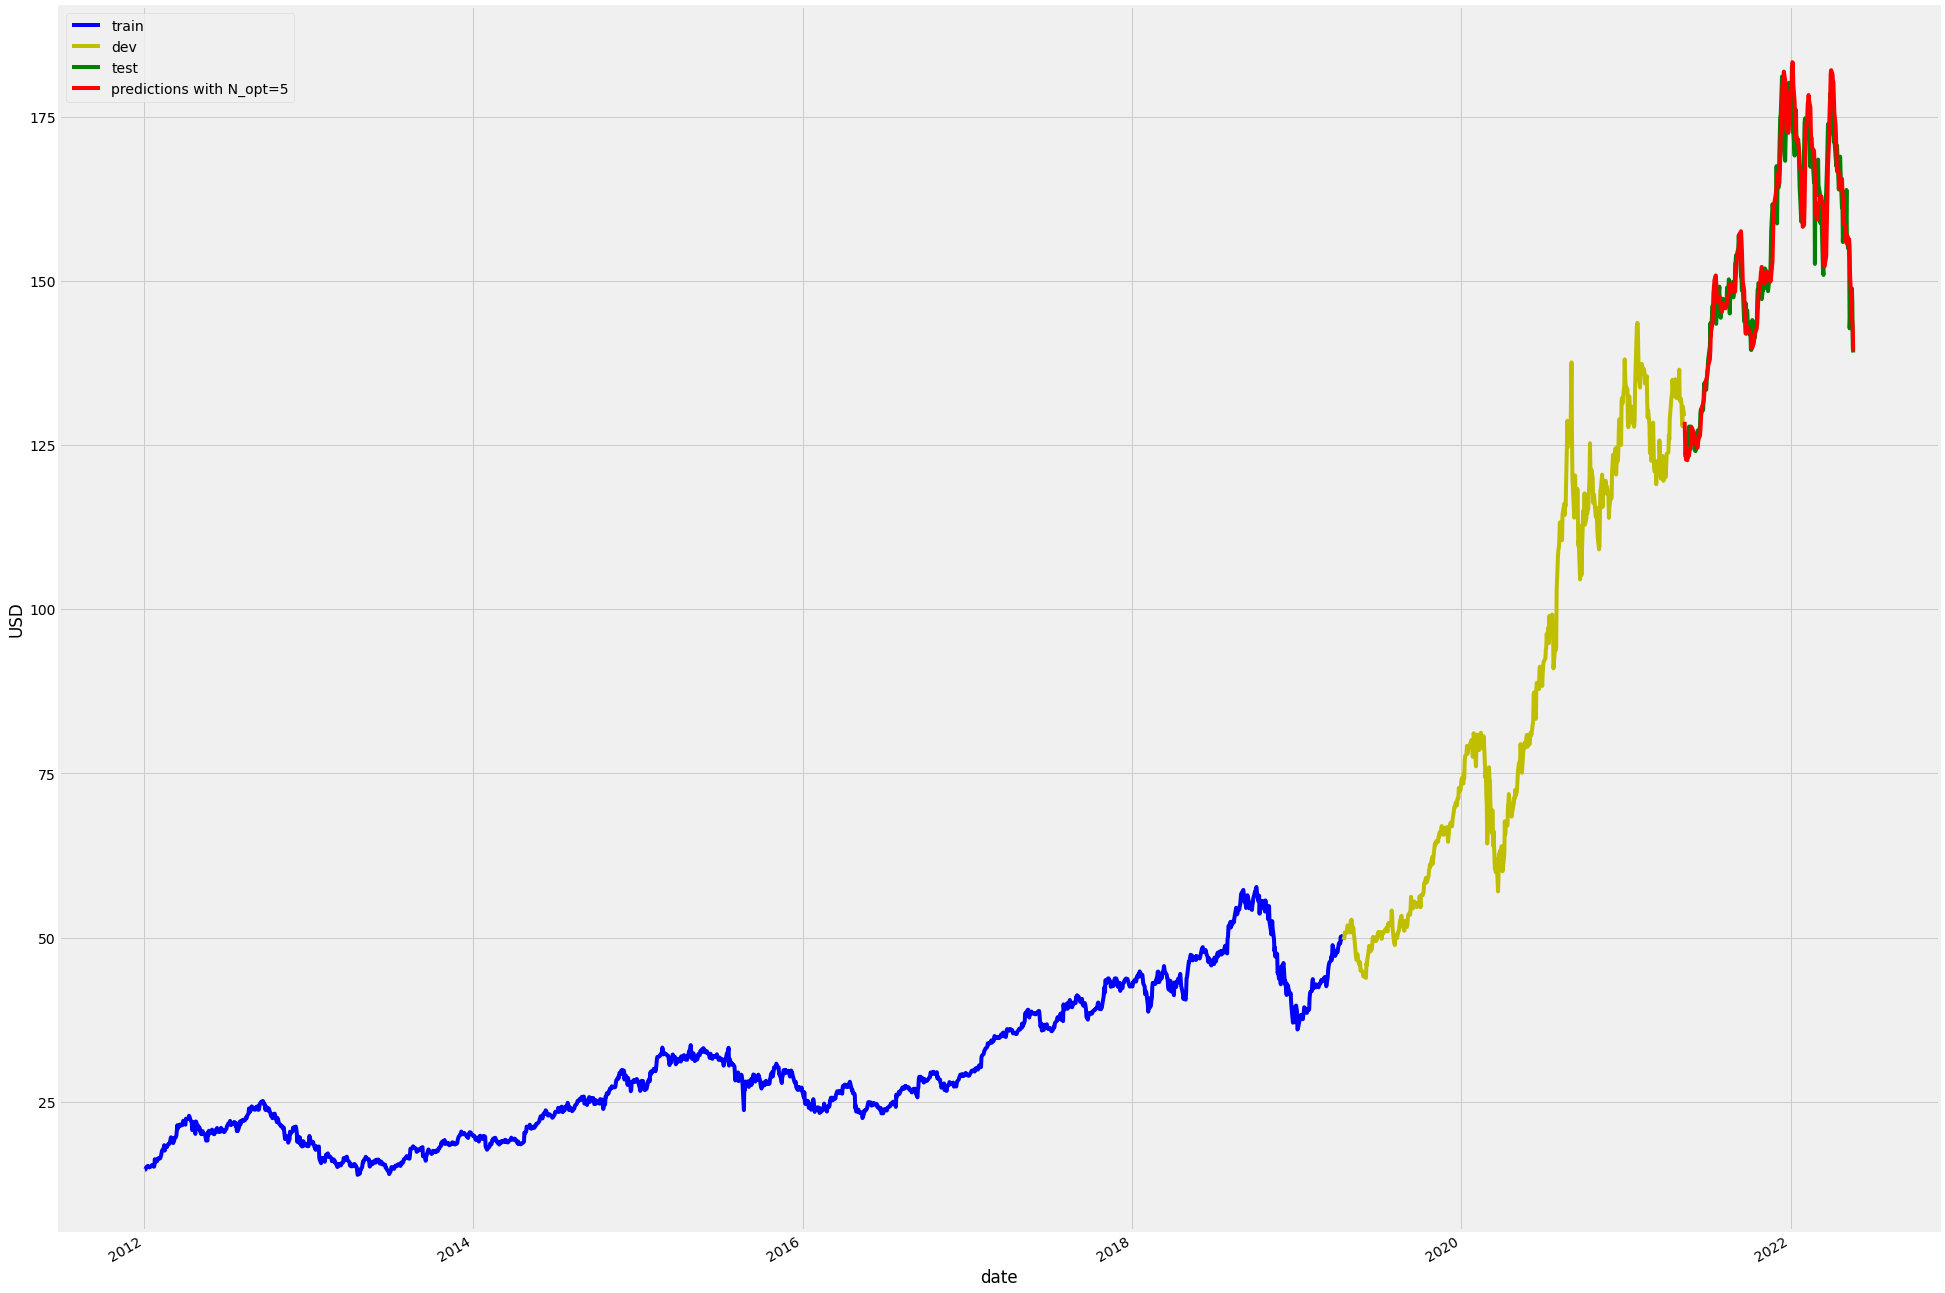

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 30, 25 # width 10, height 8

ax = train.plot(x='date', y='open', style='b-', grid=True)
ax = cv.plot(x='date', y='open', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='open', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N12', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(0.0, 226142800.0)

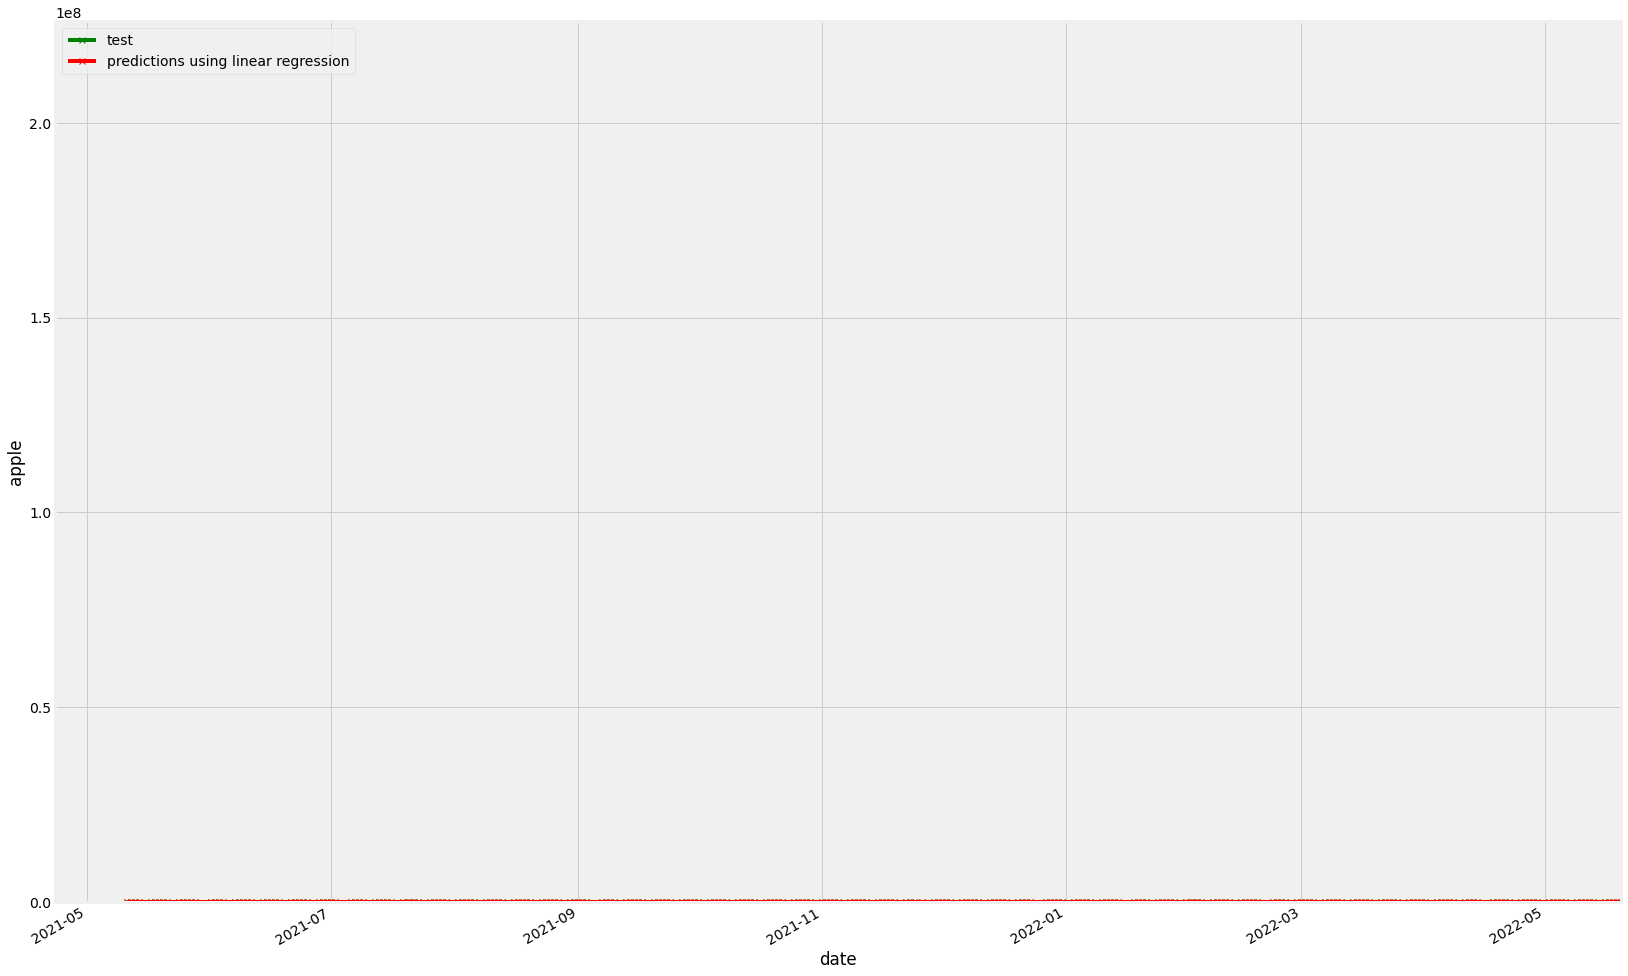

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 25, 18 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='open', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N12', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("apple")
ax.set_xlim([date(2021, 4, 23), date(2022, 5, 20)])
ax.set_ylim([0, 226142800])

In [ ]:
test.tail()

,date,open,high,low,close,adj_close,volume,month,est_N12,est_N5
2609,2022-05-16,145.550003,147.520004,144.179993,145.539993,145.539993,86643800,5,146.689242,140.233001
2610,2022-05-17,148.860001,149.770004,146.679993,149.240005,149.240005,78336300,5,144.132122,139.731000
2611,2022-05-18,146.850006,147.360001,139.899994,140.820007,140.820007,109742900,5,143.850455,145.104001
2612,2022-05-19,139.880005,141.660004,136.600006,137.350006,137.350006,136095600,5,142.400610,149.453005
2613,2022-05-20,139.089996,140.699997,132.610001,137.589996,137.589996,137194600,5,139.381065,142.710008
